In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

In [2]:
trip = pd.read_csv("/Users/wujiayou/Desktop/UF_Class/capstone/Travel_Demand/NHTS2017/trippub.csv")
house = pd.read_csv('/Users/wujiayou/Desktop/UF_Class/capstone/Travel_Demand/NHTS2017/hhpub.csv')
person = pd.read_csv('/Users/wujiayou/Desktop/UF_Class/capstone/Travel_Demand/NHTS2017/perpub.csv')

In [24]:
print("house shape:", house.shape)
print("person shape:", person.shape)


def clean_household_person(df_household: pd.DataFrame, df_person: pd.DataFrame) -> pd.DataFrame:
    df = df_household.copy()

    # (2) HHSIZE same as count of  personID
    if 'HOUSEID' in df_household.columns and 'HOUSEID' in df_person.columns and 'HHSIZE' in df_household.columns:
        person_counts = df_person.groupby('HOUSEID').size().rename('PERSON_COUNT')
        df = df.merge(person_counts, on='HOUSEID', how='left')
        df = df[df['HHSIZE'] == df['PERSON_COUNT']]
    else:
        print("⚠️ 規則 (2) 無法套用：缺少 HOUSEID 或 HHSIZE 欄位。")

    # (5) All members are in town（NHTS:  1=Yes, 2=No，so in-town 用 ==2）
    
    if {'HOUSEID','OUTOFTWN','OUTCNTRY'}.issubset(df_person.columns):
        in_town = df_person.groupby('HOUSEID').apply(
            lambda g: ((g['OUTOFTWN'] == 2) & (g['OUTCNTRY'] == 2)).all()
        )
        keep_ids = set(in_town[in_town].index)
        before = len(df)
        df = df[df['HOUSEID'].isin(keep_ids)]
        print(f"(5) 全員在城內保留戶數：{len(df)}（原本 {before}）")
    else:
        missing = list({'HOUSEID','OUTOFTWN','OUTCNTRY'} - set(df_person.columns))
        print(f"⚠️ 規則 (5) 略過：person 檔缺少欄位 {missing}")

    return df

cleaned = clean_household_person(house, person)


def select_basic_features(df: pd.DataFrame) -> pd.DataFrame:
    cols = ["HHVEHCNT", "HHSIZE", "HHFAMINC", "URBRUR", "CNTTDHH", "R_AGE_IMP", "DRIVER", "WORKER"]
    keep = [c for c in cols if c in df.columns]
    return df[keep].copy()

features = select_basic_features(cleaned)
print("features shape:", features.shape)
features.head()

house shape: (129696, 58)
person shape: (264234, 121)
(5) 全員在城內保留戶數：113962（原本 120590）
features shape: (113962, 5)


/var/folders/8j/n2lv8mpx6nn5h6b2xb3xmys80000gn/T/ipykernel_3851/1662144652.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  in_town = df_person.groupby('HOUSEID').apply(


,HHVEHCNT,HHSIZE,HHFAMINC,URBRUR,CNTTDHH
0,5,3,7,1,6
1,4,2,8,2,2
2,2,1,10,1,9
3,2,2,3,1,4
4,2,2,5,1,10


,HHVEHCNT,HHSIZE,HHFAMINC,URBRUR,CNTTDHH
count,113962.000000,113962.000000,113962.000000,113962.000000,113962.000000
mean,1.940568,1.959092,5.392087,1.227909,6.925545
std,1.181439,1.008329,3.516183,0.419486,5.657558
min,0.000000,1.000000,-9.000000,1.000000,0.000000
25%,1.000000,1.000000,4.000000,1.000000,3.000000
50%,2.000000,2.000000,6.000000,1.000000,6.000000
75%,2.000000,2.000000,7.000000,1.000000,10.000000
max,12.000000,12.000000,11.000000,2.000000,67.000000


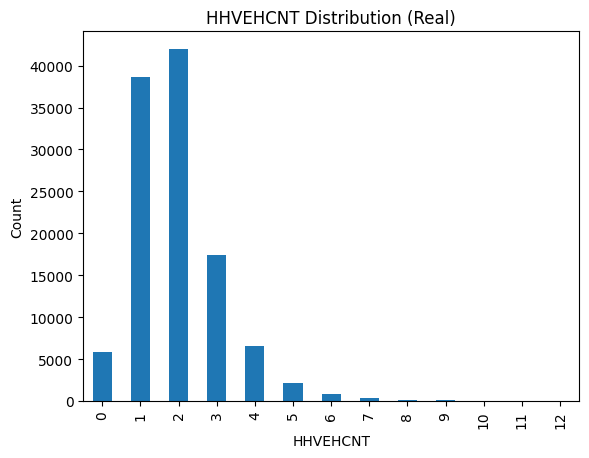

In [25]:
display(features.describe(include='all'))


if 'HHVEHCNT' in features.columns:
    ax = features['HHVEHCNT'].value_counts().sort_index().plot(kind='bar', title='HHVEHCNT Distribution (Real)')
    ax.set_xlabel('HHVEHCNT'); ax.set_ylabel('Count')
    plt.show()
else:
    print("⚠️ 找不到 HHVEHCNT，略過此圖。")

In [31]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata



metadata = SingleTableMetadata()
metadata.detect_from_dataframe(features)


synth = CTGANSynthesizer(
    metadata,
    epochs=10,          
    batch_size=256,
    pac=1,      
    verbose=True        
)
synth.fit(features)

# 存模型
model_path = '/Users/wujiayou/Desktop/UF_Class/2025Fall/EEE6778/final_pitch/ctgan_nhts.pkl'
synth.save(model_path)
print("Saved model to:", model_path)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-0.81) | Discrim. (-0.06): 100%|██████████| 10/10 [03:36<00:00, 21.65s/it]

Saved model to: /Users/wujiayou/Desktop/UF_Class/2025Fall/EEE6778/final_pitch/ctgan_nhts.pkl


Saved synthetic CSV to: /Users/wujiayou/Desktop/UF_Class/2025Fall/EEE6778/final_pitch/synth_nhts.csv


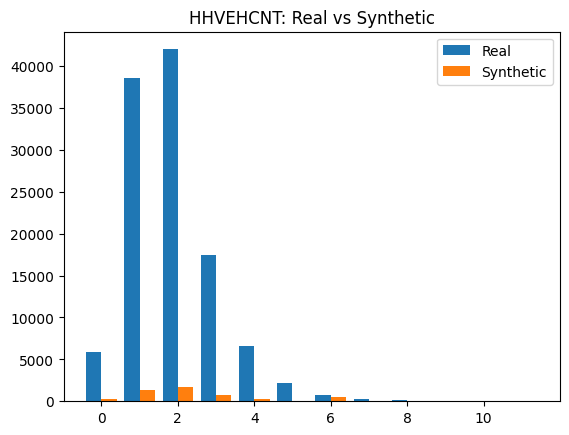

In [32]:
synthetic = synth.sample(num_rows=min(5000, len(features)))
synthetic_path = '/Users/wujiayou/Desktop/UF_Class/2025Fall/EEE6778/final_pitch/synth_nhts.csv'
synthetic.to_csv(synthetic_path, index=False)
print("Saved synthetic CSV to:", synthetic_path)


if 'HHVEHCNT' in features.columns and 'HHVEHCNT' in synthetic.columns:
    plt.hist([features['HHVEHCNT'], synthetic['HHVEHCNT']],
             bins=range(int(min(features['HHVEHCNT'].min(), synthetic['HHVEHCNT'].min())),
                        int(max(features['HHVEHCNT'].max(), synthetic['HHVEHCNT'].max())+1)),
             align='left', label=['Real','Synthetic'])
    plt.legend(); plt.title('HHVEHCNT: Real vs Synthetic')
    plt.show()
else:
    print("⚠️ HHVEHCNT 不在兩邊資料中，略過對照圖。")


In [ ]:
import numpy as np
from scipy.stats import ks_2samp

def kolmogorov_smirnov(real: pd.Series, synth: pd.Series):
    r = pd.to_numeric(real, errors='coerce').dropna()
    s = pd.to_numeric(synth, errors='coerce').dropna()
    if len(r) > 5 and len(s) > 5:
        stat, p = ks_2samp(r, s)
        return {'ks_stat': float(stat), 'p_value': float(p)}
    return {'ks_stat': None, 'p_value': None}

def correlation_distance(real_df: pd.DataFrame, synth_df: pd.DataFrame):
    rc = real_df.corr(numeric_only=True).fillna(0.0)
    sc = synth_df.corr(numeric_only=True).fillna(0.0)
    
    common = [c for c in rc.columns if c in sc.columns]
    if not common:
        return None
    diff = np.abs(rc.loc[common, common].values - sc.loc[common, common].values)
    return float(diff.mean())

# calculate KS
report = {'per_feature_ks': {}, 'mean_corr_distance': None}
common_cols = [c for c in features.columns if c in synthetic.columns]

for c in common_cols:
    if pd.api.types.is_numeric_dtype(features[c]):
        report['per_feature_ks'][c] = kolmogorov_smirnov(features[c], synthetic[c])

report['mean_corr_distance'] = correlation_distance(features[common_cols], synthetic[common_cols])
report

{'per_feature_ks': {'HHVEHCNT': {'ks_stat': 0.09063109808532677,
   'p_value': 1.0939347753528342e-34},
  'HHSIZE': {'ks_stat': 0.02332350432600344, 'p_value': 0.010735739761665992},
  'HHFAMINC': {'ks_stat': 0.018560169179200114,
   'p_value': 0.07283983579480369},
  'URBRUR': {'ks_stat': 0.24129069689896632,
   'p_value': 5.947422782578853e-246},
  'CNTTDHH': {'ks_stat': 0.1852840385391622,
   'p_value': 2.0481349646454095e-144}},
 'mean_corr_distance': 0.04281360820934006}